# Behavior of the Adaline convergence
Below we import the entire Adaline code from the previous example:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(0)

In [4]:
# module for file access
import os.path

# global file name of our data source
file_name = 'iris.csv'

def fetch_iris_data():
    '''
    Fetch data from an internet archive and save as file `iris.csv`.
    '''

    df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                     header=None)
    df.to_csv(file_name, header=None, index=False)

    return

# fetch data from internet source only if the file is not available locally
if not os.path.exists(file_name):
    fetch_iris_data()
    
df = pd.read_csv(file_name, header=None)

In [5]:
def prep_iris_data(df):
    ''' 
    Fetches 2d data points from the iris data from the pandas dataframe `df` and
    return (X, Y), where X is a list of 2d points and Y a list of labels.
    '''
    
    # as feature we take the first two data entries,
    # which are sepal length and width
    X = df.iloc[:, 0:2].values

    # read class labels and convert them to numers as follow:
    # `iris-setosa` set to value -1, `iris-versicol` as well as `iris-virginica` to value 1
    Y = df.iloc[:, 4].values 
    Y = np.where(Y == 'Iris-setosa', -1, 1)
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand), np.array(Y_rand)

In [6]:
def plot_data(X, Y):
    '''
    Plot the data X, setosa in red, and others in blue.
    '''

    # divide data depedning on the label: iris-setosa or other
    X_setosa = []
    X_other = []
    for x, y in zip(X, Y):
        if y == -1:
            X_setosa.append(x)
        else:
            X_other.append(x)
   
    # convert to numpy array
    X_setosa = np.array(X_setosa)
    X_other = np.array(X_other)

    # plot the two lists with different styles
    plt.scatter(X_setosa[:, 0], X_setosa[:, 1], color='red', marker='o', label='setosa')
    plt.scatter(X_other[:, 0], X_other[:, 1], color='blue', marker='o', label='other')

    # decorate plot
    plt.xlabel('sepal length')
    plt.ylabel('sepal width')
    plt.legend(loc='upper right')

    return

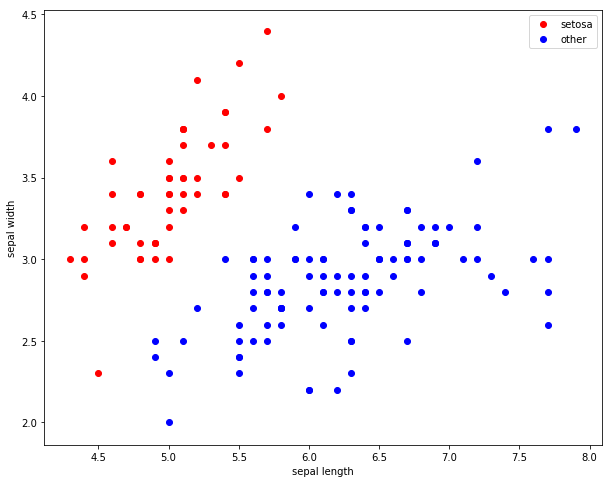

In [7]:
X_all, Y_all = prep_iris_data(df)

plot_data(X_all, Y_all)

In [8]:
class Adaline:

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the Adaline, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = np.zeros(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.0, 1, -1)
    
    def learn(self, X_train, Y_train, eta=0.01, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        # we initialize two list, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []

        # for all the epoch
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)
            
            # compute the activation input of the entire traning features
            output = self.activation_input(X_train)
            # and then the deviation from the labels
            delta = Y_train - output
            # the following is an implmentation of the adaline update rule
            self.w_[1:] += eta * X_train.T.dot(delta)
            self.w_[0] += eta * delta.sum()
            # and finally, we record the loss function
            loss = (delta ** 2).sum() / 2.0
            # and save it for later use
            self.train_loss_.append(loss)

        return
    
    def plot_train_loss(self):
        '''
        plots the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, num_errs = np.arange(len(self.train_loss_)), np.array(self.train_loss_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('cost')
        axs.set_title('Loss during training')
        plt.plot(epochs, num_errs)

        return

    def plot_decision_regions(self, X, Y, X_train, Y_train, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the Adaline classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.4, cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())
        
        # sort the input data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X, Y):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)

        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='.', label='Setosa')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='.', label='Other')
        
        # sort the training data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X_train, Y_train):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)
        
        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='x', label='S. training')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='x', label='O. training')

        # add some additional annotations of the plot
        axs.set_xlabel('sepal length')
        axs.set_ylabel('sepal width')
        axs.legend(loc='upper right')
        axs.set_title('Adaline')

        return

    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

## Dependence on learning rates
Our objective is to visualize the learning process and get an idea about the dependence on training data as well as the learning rate.

First we look at two training phases with learning rates that are two orders of magnitude apart.

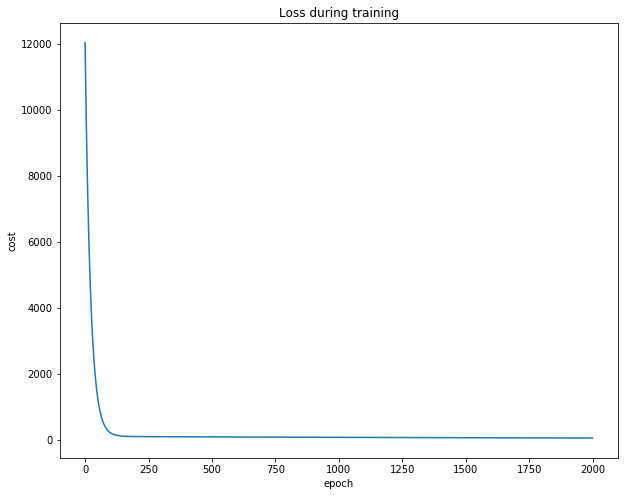

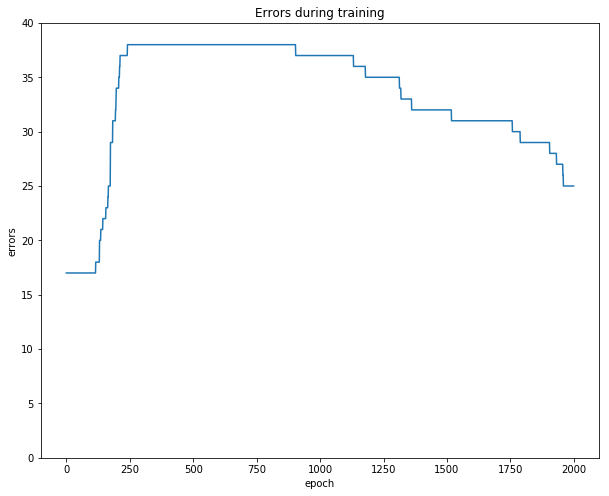

Efficiency (train) = 0.5
Efficiency (test)  = 0.53
Efficiency (all)   = 0.52


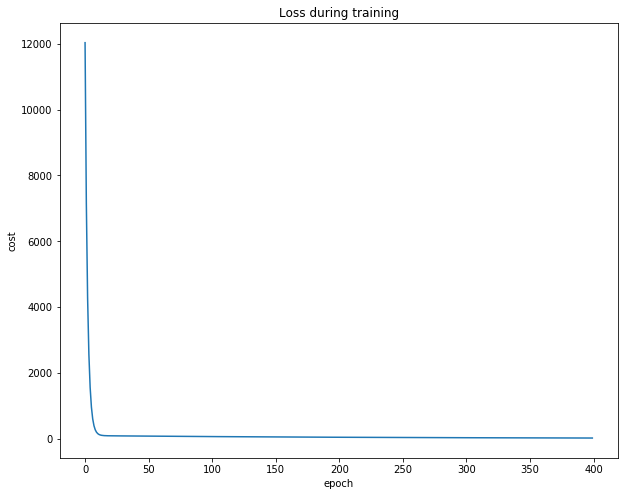

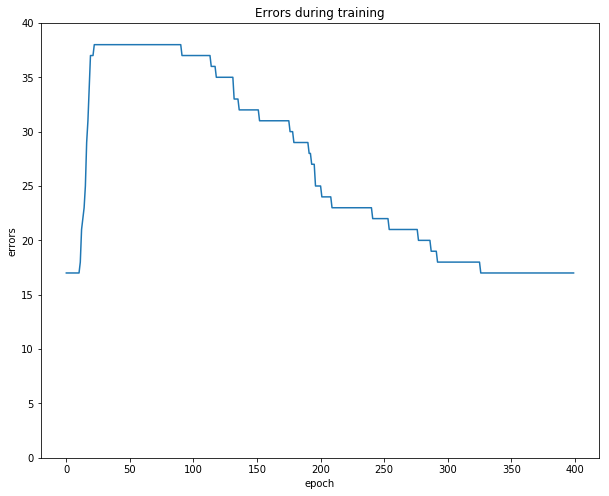

Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


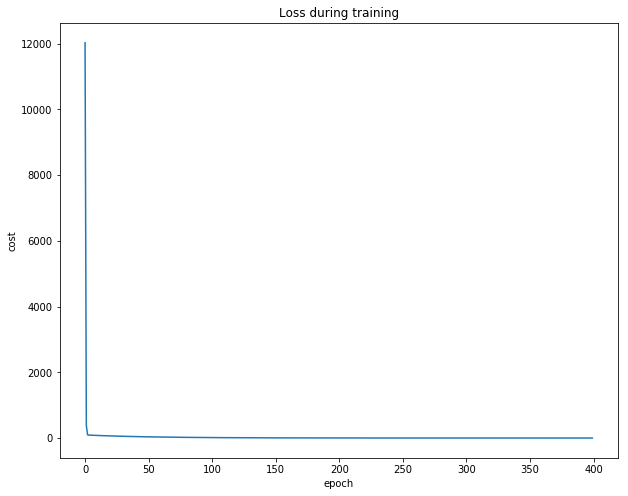

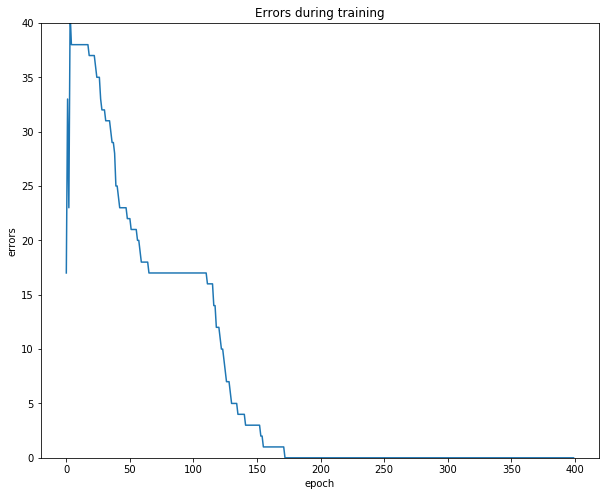

Efficiency (train) = 1.0
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9933333333333333


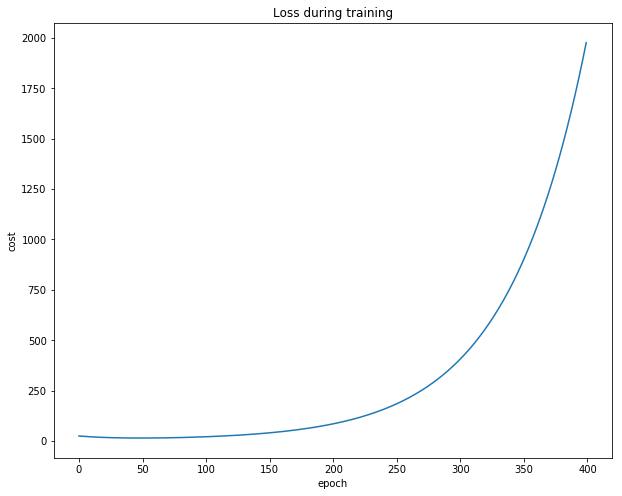

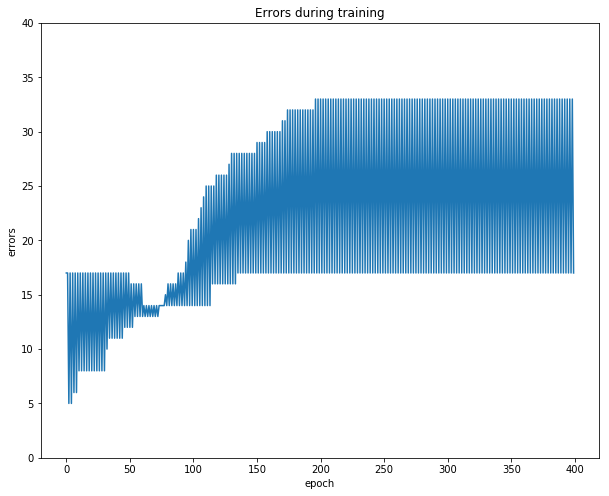

Efficiency (train) = 0.33999999999999997
Efficiency (test)  = 0.32999999999999996
Efficiency (all)   = 0.33333333333333337


In [9]:
np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.w_ = np.array([1, 2, 3], dtype=np.float64)
ada.learn(X_train, Y_train, eta=0.00001, epochs=2000)
ada.plot_train_loss()
ada.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.w_ = np.array([1, 2, 3], dtype=np.float64)
ada.learn(X_train, Y_train, eta=0.0001, epochs=400)
ada.plot_train_loss()
ada.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.w_ = np.array([1, 2, 3], dtype=np.float64)
ada.learn(X_train, Y_train, eta=0.0005, epochs=400)
ada.plot_train_loss()
ada.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.learn(X_train, Y_train, eta=0.00087, epochs=400)
ada.plot_train_loss()
ada.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Oberserve how smmoth the decay loss per epochs is compared to the number of errors per epoch. Clearly there is a relation between the loss function and the number of errors, however, this relation is not a simple one. There are long periods in which the loss function decreases rapidly while the number of error is still high. Thus, the loss function should be seen as the driver of the learning process but the number of errors as the benchmark of the performances.

Note, however, while the Perceptron did not depend so much on how large the learning rate was adapted, the Adaline seems to be very dependent on the magnitude of the learning rate. Clearly, when it is low, we need many epochs to approach an optimal choice of weights. However, if we adjust it too high, we might even drive the choice of weights out of regions of optimal weights.

**HOMEWORK:** How can this phenomenon be explained?

### Sequence of decission boundaries per epoch
Next let us visualize what updates occur during the training.

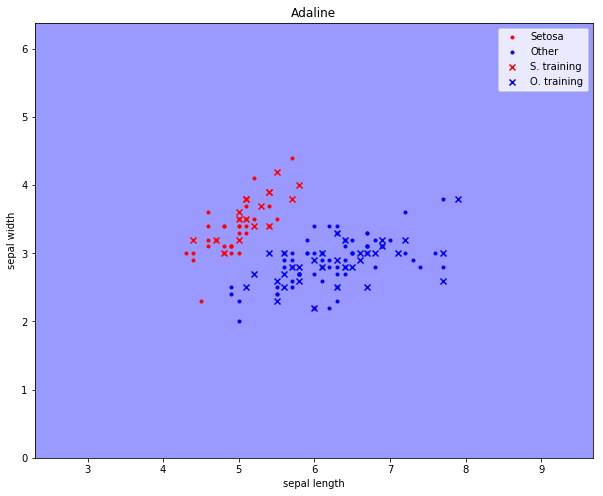

Epoch: 0
weights: [1. 2. 3.]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


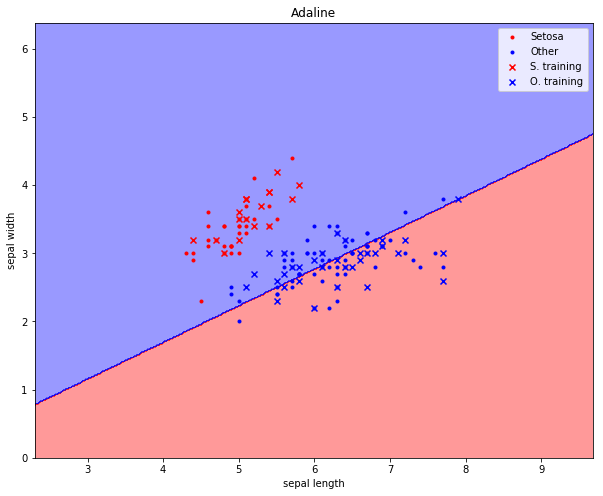

Epoch: 1
weights: [ 0.4821467  -0.56493912  1.05145733]
Efficiency (train) = 0.26
Efficiency (test)  = 0.32999999999999996
Efficiency (all)   = 0.30666666666666664


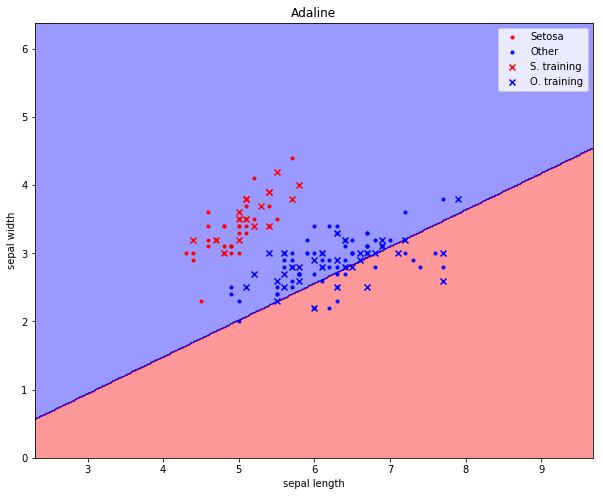

Epoch: 2
weights: [ 0.44361312 -0.35159275  0.65238519]
Efficiency (train) = 0.5
Efficiency (test)  = 0.53
Efficiency (all)   = 0.52


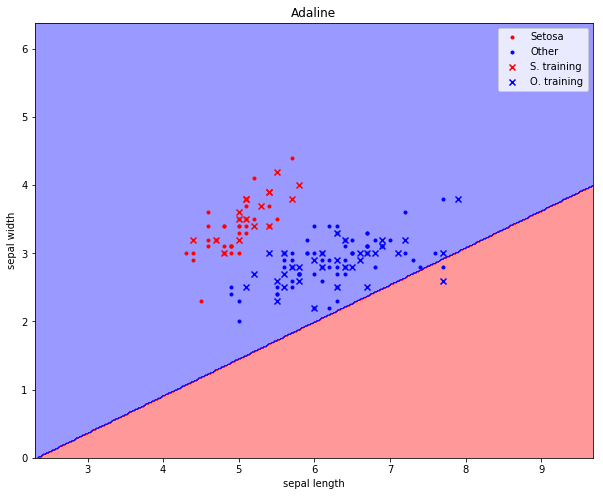

Epoch: 3
weights: [ 0.4121441  -0.17584022  0.32354545]
Efficiency (train) = 0.64
Efficiency (test)  = 0.6599999999999999
Efficiency (all)   = 0.6533333333333333


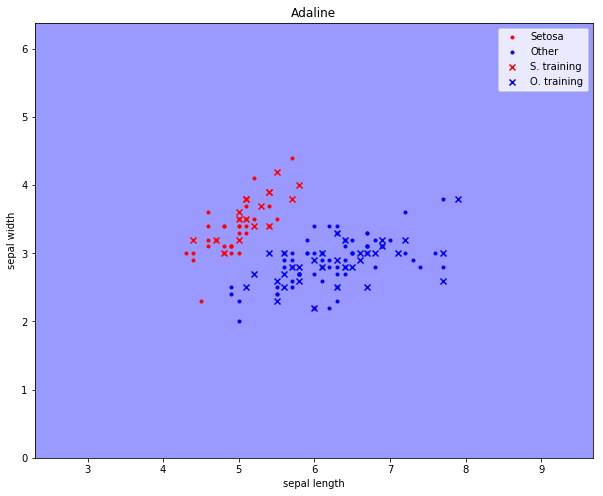

Epoch: 4
weights: [ 0.3864945  -0.03106143  0.05257082]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


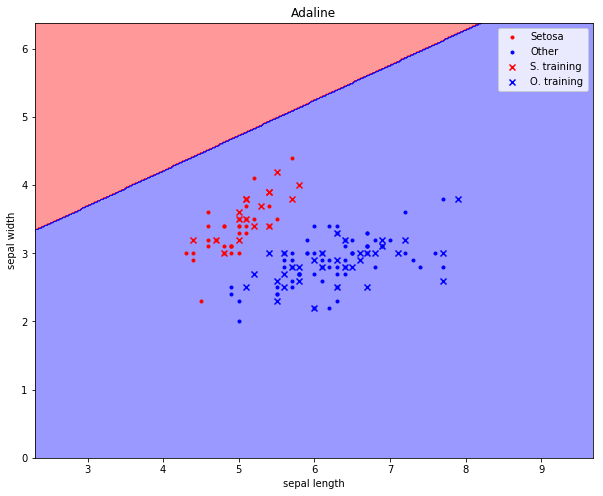

Epoch: 5
weights: [ 0.36563847  0.088198   -0.17072817]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


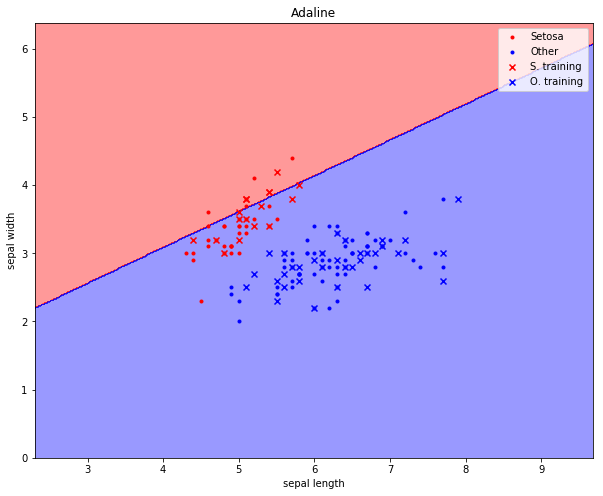

Epoch: 6
weights: [ 0.34873081  0.18643194 -0.35474674]
Efficiency (train) = 0.76
Efficiency (test)  = 0.72
Efficiency (all)   = 0.7333333333333334


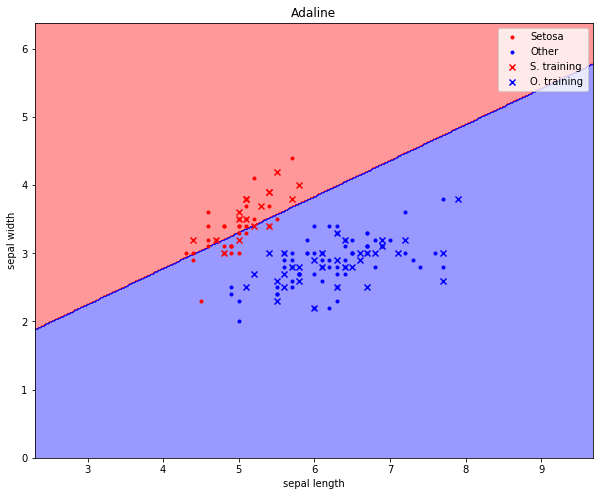

Epoch: 7
weights: [ 0.33507514  0.26734294 -0.50640172]
Efficiency (train) = 0.92
Efficiency (test)  = 0.87
Efficiency (all)   = 0.8866666666666667


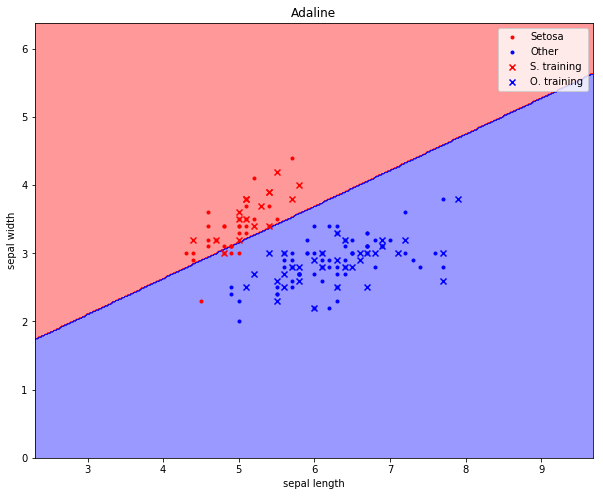

Epoch: 8
weights: [ 0.32409773  0.33398154 -0.63139196]
Efficiency (train) = 0.98
Efficiency (test)  = 0.9299999999999999
Efficiency (all)   = 0.9466666666666667


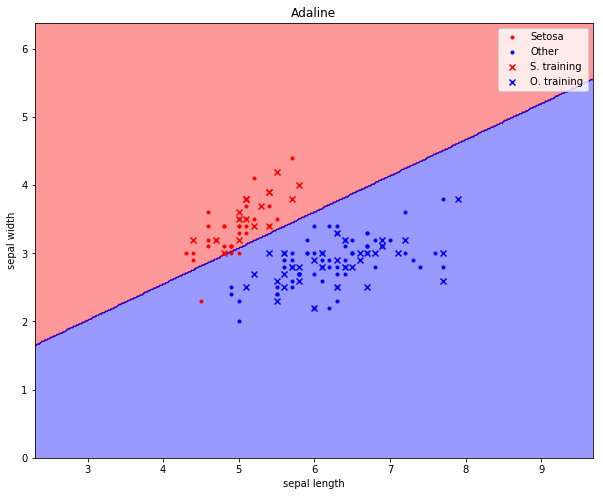

Epoch: 9
weights: [ 0.31532587  0.38886112 -0.73441279]
Efficiency (train) = 1.0
Efficiency (test)  = 0.97
Efficiency (all)   = 0.98


In [10]:
np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

ada = Adaline(X.shape[1])
ada.w_ = np.array([1, 2, 3], dtype=np.float64)

for e in range(10):
    
    ada.plot_decision_regions(X, Y, X_train, Y_train, 0.02)
    eff_all = ada.efficiency(X_all, Y_all)
    
    eff_train = ada.efficiency(X_train, Y_train)
    eff_test = ada.efficiency(X, Y)
    eff_all = ada.efficiency(X_all, Y_all)
    
    plt.show()

    print('Epoch:', e )
    print('weights:', ada.w_)
    print('Efficiency (train) =', eff_train)
    print('Efficiency (test)  =', eff_test)
    print('Efficiency (all)   =', eff_all)
    
    ada.learn(X_train, Y_train, eta=0.0005, epochs=20)

Note that our initial weight is chosen so unlucky that the Adaline must reverse the classification. This reversal happens at the very beginning from which the spike in the number of errors per epoch results.

## Dependence on bad points
The Adaline behaves better compared to the Perceptron when there are training data points that violate the linear separability strongly.

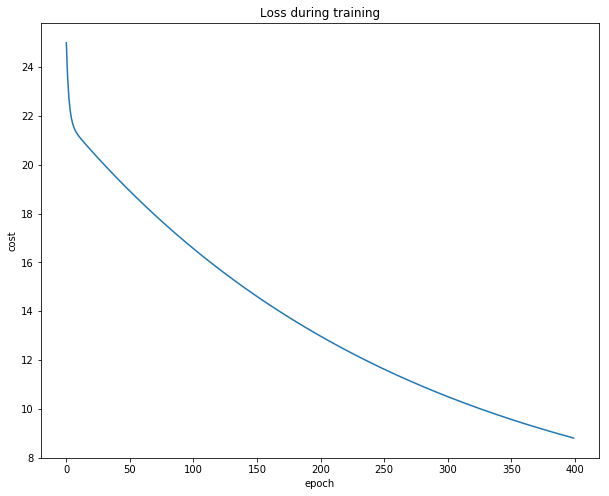

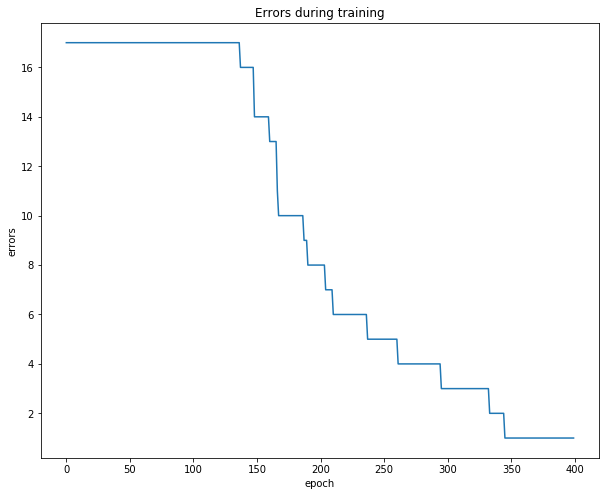

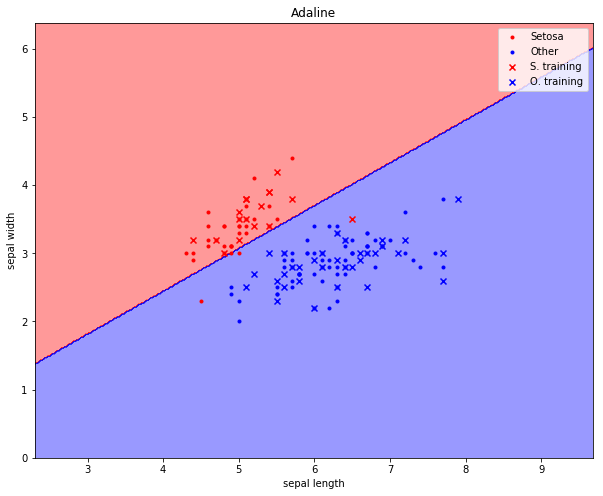

weights: [-0.04179315  0.37520438 -0.59748804]
Efficiency (train) = 0.98
Efficiency (test)  = 0.97
Efficiency (all)   = 0.9733333333333334


In [11]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(4)
# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.learn(X_train, Y_train, eta=0.0001, epochs=400)
ada.plot_train_loss()
ada.plot_train_errors()

ada.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

plt.show()

print('weights:', ada.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

We observe, compared to the Perceptron, the Adaline seems to produce good result even though we introduce the additional 'bad point'. Let us visualize what happens during the training.

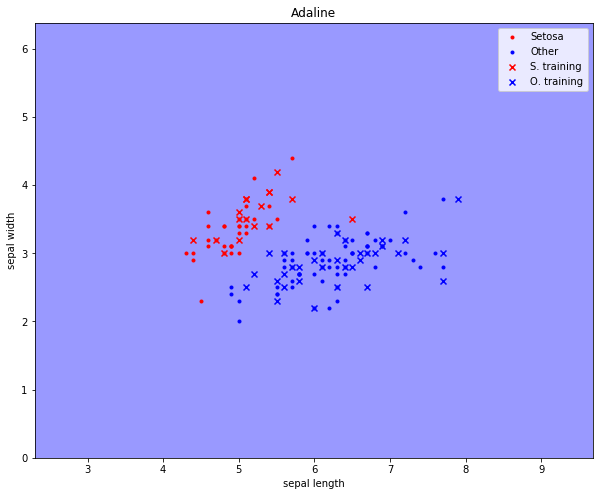

Epoch: 0
weights: [0. 0. 0.]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


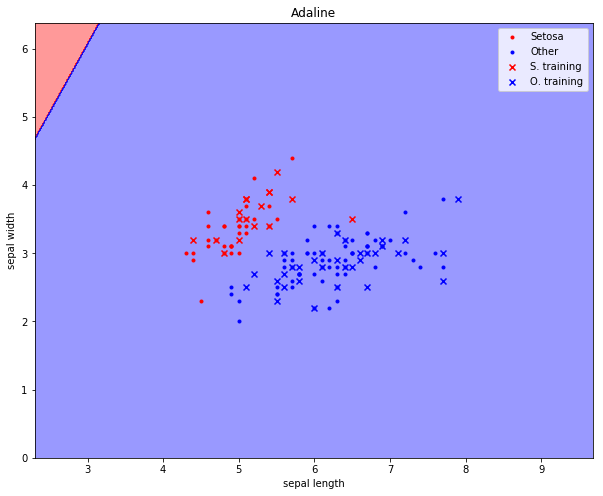

Epoch: 1
weights: [ 0.00217022  0.08054381 -0.04012716]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


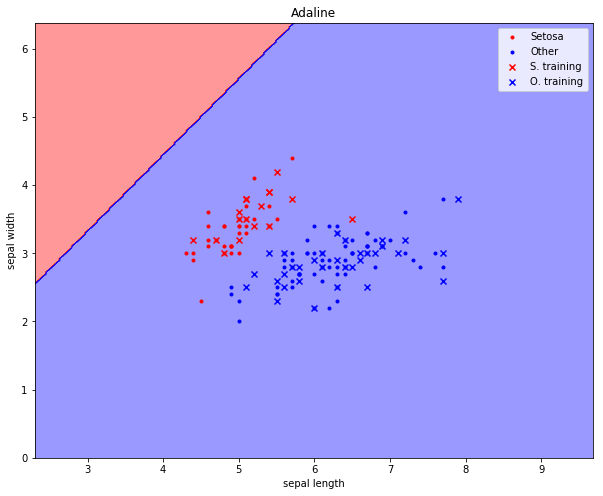

Epoch: 2
weights: [-0.0030315   0.11270361 -0.10078964]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


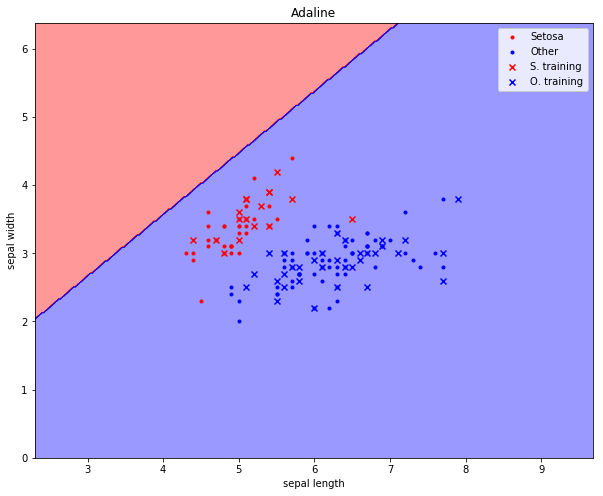

Epoch: 3
weights: [-0.00788939  0.14310254 -0.15819079]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


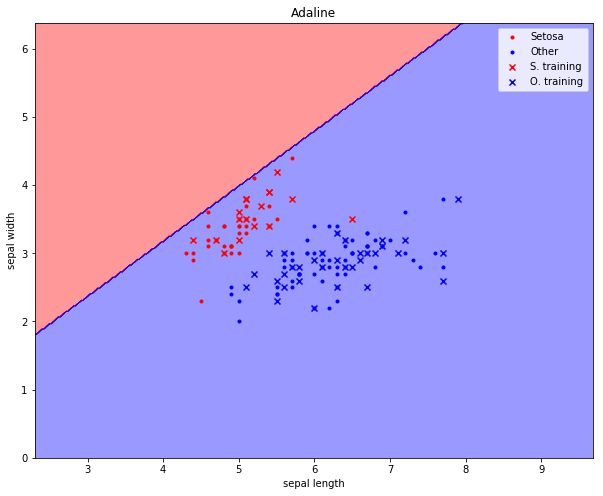

Epoch: 4
weights: [-0.01241938  0.17185221 -0.21249847]
Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


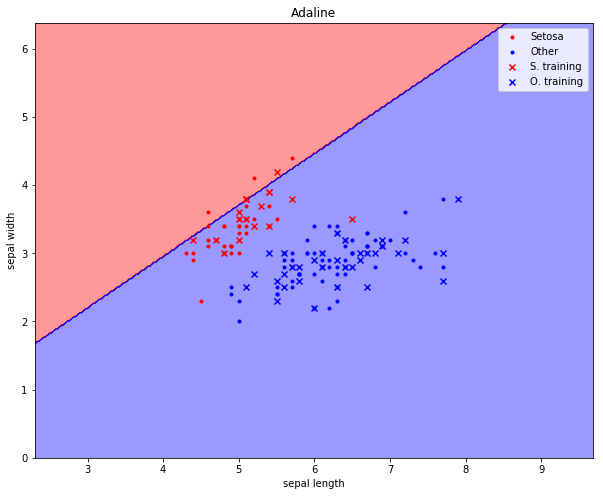

Epoch: 5
weights: [-0.01663929  0.1990418  -0.26387991]
Efficiency (train) = 0.72
Efficiency (test)  = 0.71
Efficiency (all)   = 0.7133333333333334


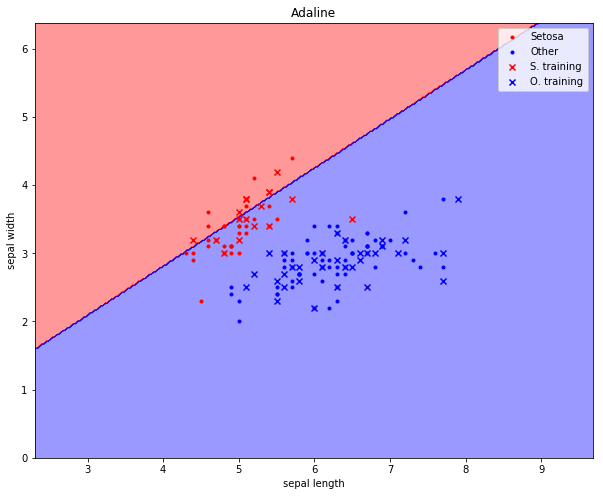

Epoch: 6
weights: [-0.02056595  0.22475567 -0.31249331]
Efficiency (train) = 0.8
Efficiency (test)  = 0.75
Efficiency (all)   = 0.7666666666666666


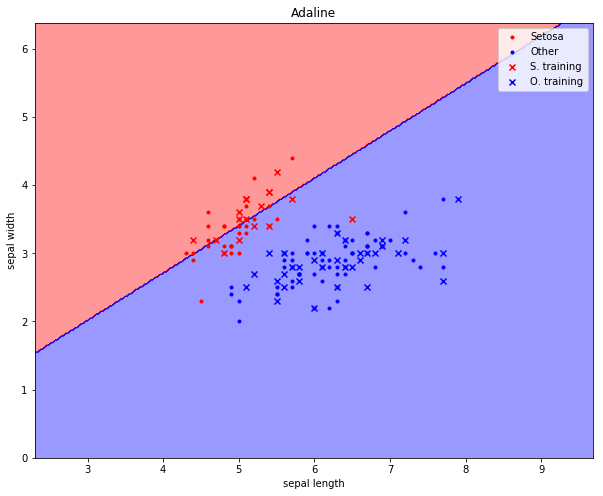

Epoch: 7
weights: [-0.0242153   0.2490736  -0.35848832]
Efficiency (train) = 0.88
Efficiency (test)  = 0.8200000000000001
Efficiency (all)   = 0.84


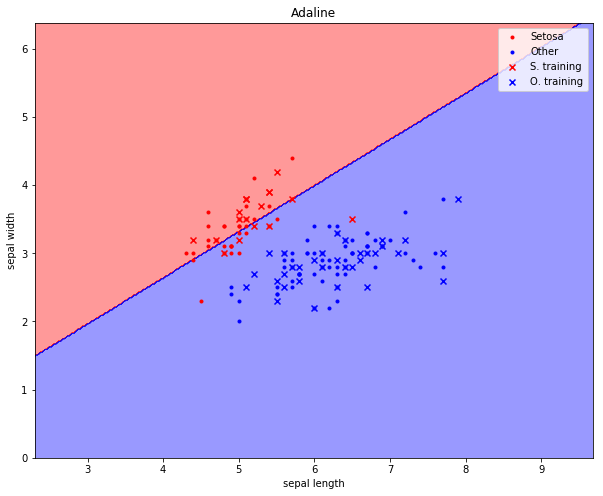

Epoch: 8
weights: [-0.0276024   0.27207108 -0.4020065 ]
Efficiency (train) = 0.9
Efficiency (test)  = 0.87
Efficiency (all)   = 0.88


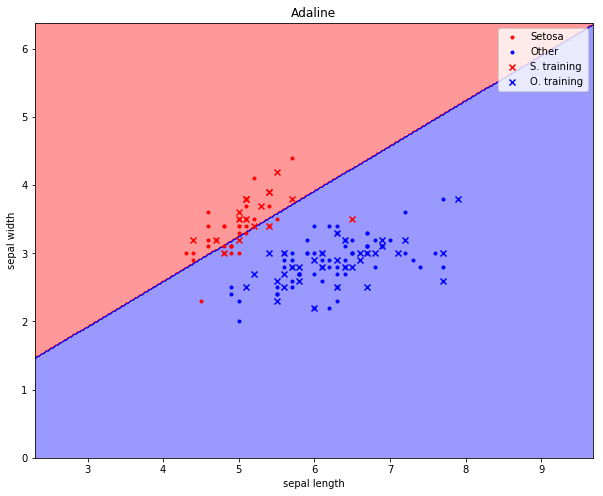

Epoch: 9
weights: [-0.03074151  0.2938195  -0.44318174]
Efficiency (train) = 0.92
Efficiency (test)  = 0.89
Efficiency (all)   = 0.9


In [12]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(4)
# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

ada = Adaline(X.shape[1])

for e in range(10):
    
    ada.plot_decision_regions(X, Y, X_train, Y_train, 0.02)
    eff_all = ada.efficiency(X_all, Y_all)
    
    eff_train = ada.efficiency(X_train, Y_train)
    eff_test = ada.efficiency(X, Y)
    eff_all = ada.efficiency(X_all, Y_all)
    
    plt.show()

    print('Epoch:', e )
    print('weights:', ada.w_)
    print('Efficiency (train) =', eff_train)
    print('Efficiency (test)  =', eff_test)
    print('Efficiency (all)   =', eff_all)
    
    ada.learn(X_train, Y_train, eta=0.0001, epochs=30)

## Random data
The final section below can be used to study the Adaline training algorithm with random data that is almost linearly separable. Play with the seed and learning rate to observe the training performance.

**HOMEWORK:** 
1. Classify the different scenarios and give explanations why the occur.
2. Is there a relation between a 'good' learning rate and the training data? HINT: For one data set, find a learning rate that allows sufficiently good efficiency. Scale the training data linearly and find again a good learning rate. How do the two learning rate relate to each other and what would be good practise when preparing the data set before training?

In [13]:
def generate_random_data(numItems, vecSize=2):
    '''
    generates num items of radom data
    Y: an array of classes '-1 or 1'
    X: the corresponding data vectors
    '''
    
    # generate class labels -1 and 1
    Y = np.ones(numItems) - 2 * np.random.randint(2, size=numItems)

    # generate the data on basis of which the distinction should be made
    X = np.random.rand(numItems, vecSize)

    for n in range(vecSize):
        X[:, n] = X[: ,n] - 2 * Y * np.random.rand(numItems)

    return X, Y

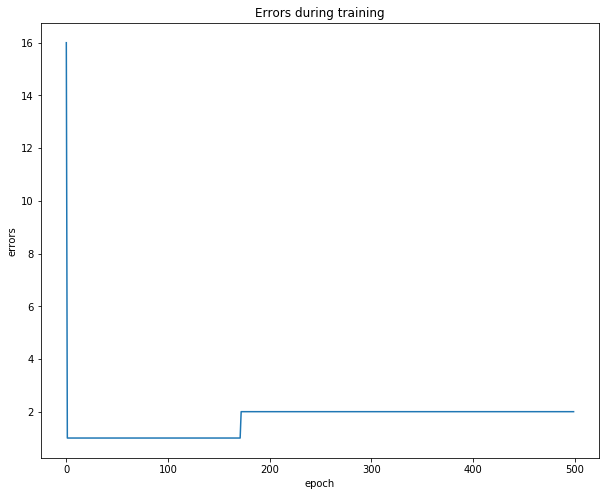

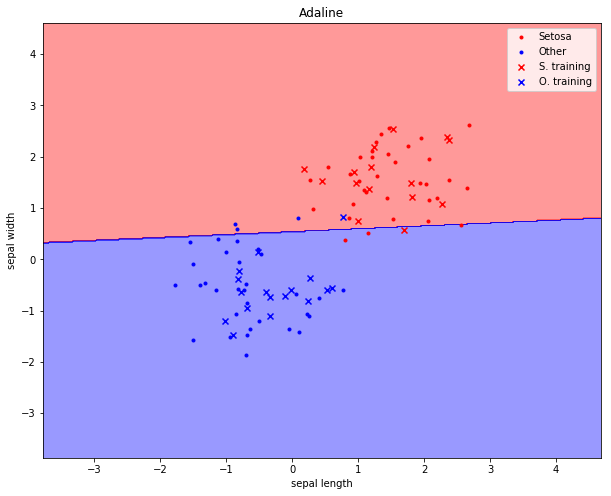

NameError: name 'ppn' is not defined

In [14]:
# if you do not have the csv data file call fetch_iris_data() by removing the comment in the line below
# fetch_iris_data()

X_all, Y_all = generate_random_data(100)

# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )

# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ada = Adaline(X.shape[1])
ada.learn(X_train, Y_train, eta=0.001, epochs=500)
ada.plot_train_errors()

ada.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = ada.efficiency(X_train, Y_train)
eff_test = ada.efficiency(X, Y)
eff_all = ada.efficiency(X_all, Y_all)

plt.show()

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)